In [1]:
# Imports
import gymnasium as gym
import numpy as np
import random
from environments.grid_world import GridWorldEnv
import matplotlib.pyplot as plt

In [2]:
### Deterministic GridWorld
gym.register(
    id="gymnasium_env/GridWorld-v2",
    entry_point=GridWorldEnv,
    max_episode_steps=300,  # Prevent infinite episodes
)

In [3]:
# Environment
env = gym.make("gymnasium_env/GridWorld-v2", render_mode='rgb_array')
env.reset()
num_states = env.observation_space.n
num_actions = env.action_space.n

In [4]:
# SARSA Class
class SARSA:
    def __init__(self, env, num_states, num_actions):
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.Q = np.zeros((self.num_states, self.num_actions))
        self.policy = {state: 0 for state in range(self.num_states)}

    def select_action(self, state, epsilon=.2):
        if np.random.rand() < epsilon:
            return np.random.choice(self.num_actions)
        return np.argmax(self.Q[state])

    def update_q_table(self, state, action, reward, next_state, next_action, alpha=.1, gamma=.8):
        old_q_value = self.Q[state, action]
        new_q_value = self.Q[next_state, next_action]
        self.Q[state, action] = old_q_value + alpha * (reward + gamma * new_q_value - old_q_value)

    def get_policy(self):
        for state in range(self.num_states):
            self.policy[state] = np.argmax(self.Q[state]) # Action with the highest Q-value

    def train(self, num_episodes=1000):
        for _ in range(num_episodes):
            state, _ = env.reset()
            action = self.select_action(state)
            terminated = False
            while not terminated:
                next_state, reward, terminated, _, _ = env.step(action)
                next_action = self.select_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)
                state, action = next_state, next_action

    def evaluate(self, num_episodes=1):
        self.get_policy()
        episode_total_reward = 0
        for _ in range(num_episodes):
            state, _ = env.reset()
            terminated = False
            while not terminated:
                action = self.policy[state] # Take best action based on learned policy
                next_state, reward, terminated, _, _ = env.step(action)
                state = next_state
                episode_total_reward += reward
            print(f"Total collected rewards: {episode_total_reward}")

In [5]:
sarsa = SARSA(env, num_states, num_actions)
sarsa.train()

In [6]:
sarsa.evaluate()

Total collected rewards: 7.0


In [7]:
# Actions are represented as: (3 → left, 2 → down, 1 → right, 0 → up).
sarsa.policy

{0: np.int64(2),
 1: np.int64(1),
 2: np.int64(2),
 3: np.int64(1),
 4: np.int64(1),
 5: np.int64(2),
 6: np.int64(1),
 7: np.int64(1),
 8: np.int64(0)}

In [8]:
sarsa.Q

array([[ 0.27683007,  0.9411847 ,  1.94586491,  0.41867237],
       [-0.08178885,  3.4063297 ,  1.8048625 , -0.29947129],
       [ 1.77018094,  1.85510502,  6.07529196,  0.10031228],
       [-0.02156682,  4.03642962,  3.08256164,  1.68448954],
       [ 1.20214633,  6.90903752,  6.22102262,  1.49797642],
       [ 2.95433241,  6.3468016 , 10.        ,  3.78855797],
       [ 0.5010993 ,  6.32379843,  0.27674576,  0.55964793],
       [ 1.50633981,  9.9993144 ,  0.99851199,  0.21343741],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

/opt/anaconda3/envs/reinforcement-learning-notes/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:334: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


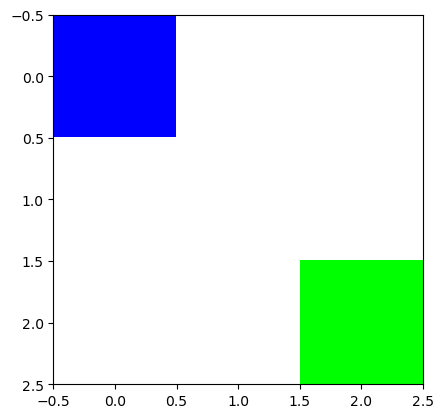

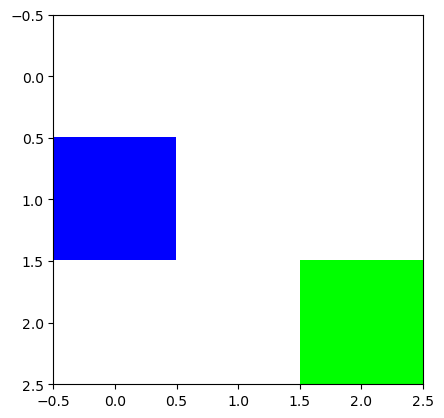

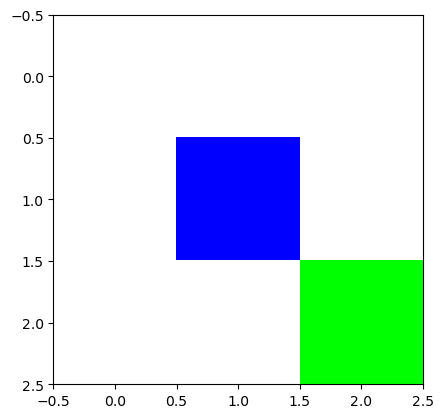

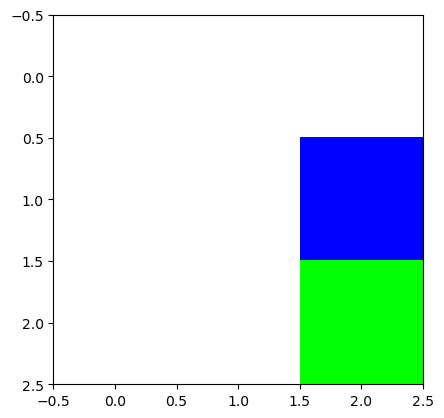

<Figure size 640x480 with 0 Axes>

In [9]:
def simulate_policy(env, policy, pause=0.5):
    state, _ = env.reset()

    done = False
    while not done:
        # Render
        img = env.render()
        if img is not None:
            plt.imshow(img)
            plt.axis('on')
            plt.show(block=False)
            plt.pause(pause)
            plt.clf()

        # Take action from policy
        action = policy[state]
        state, reward, done, _, _ = env.step(action)

simulate_policy(env, sarsa.policy, pause=0.7)

In [18]:
# Visualise the Value Function
def visualize_value_function(agent, agent_name="PI", env_size=3):
    """
    Display the state values as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    
    # Populate the value grid with state values
    value_grid = np.array([np.max(agent.Q[state]) for state in range(num_states)]).reshape(env_size, env_size)
    
    # Create the heatmap visualization
    plt.imshow(value_grid, cmap='viridis')
    plt.colorbar(label='State Value')
    plt.title('Learned State Values')
    
    # Add value text in each cell for precision
    for row in range(env_size):
        for col in range(env_size):
            value = value_grid[row, col]
            text_color = "white" if value < 0.5 * np.max(value_grid) else "black"
            plt.text(col, row, f"{value:.2f}",
                     ha="center", va="center", color=text_color)
    plt.show()
    plt.savefig(f"visualisations/{agent_name}_value_function.png")
    plt.close()
    print("Value function visualisation saved")

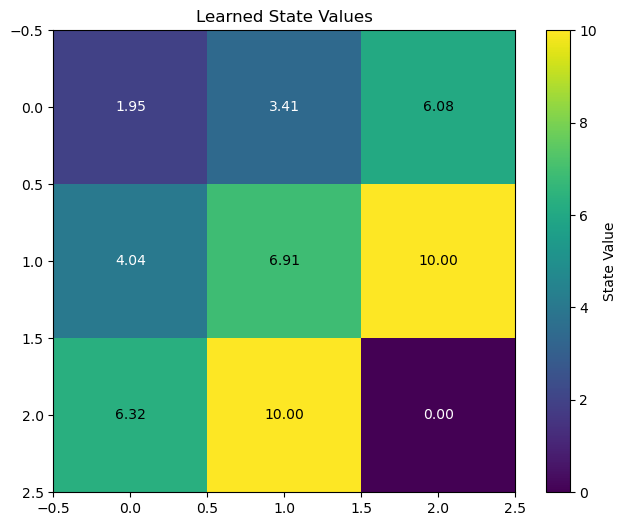

Value function visualisation saved


In [19]:
visualize_value_function(sarsa, agent_name="SARSA")